In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Purpose: Drop runs with bad GC distribution


After running trimmomatic on all the reads, ran fastqc on all trimmed samples. GC distribution:

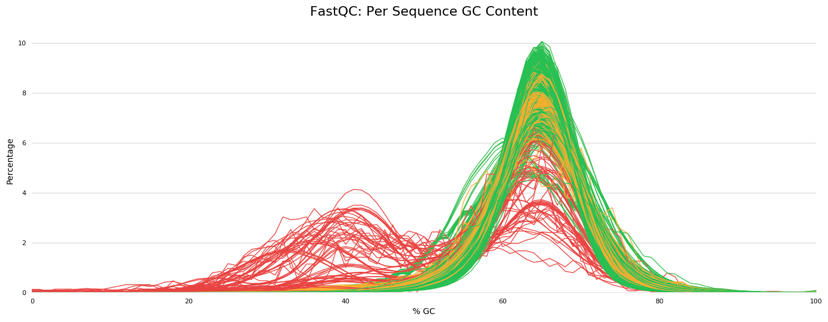

Want to drop the samples that fail because they look like they are likely contaminated, then rewrite the summary runs file for input into smake

In [6]:
import pandas as pd

In [7]:
#read in multiqc report
mqc=pd.read_csv("multiqc_fastqc.txt", sep='\t', quotechar=None, quoting=3)
mqc.head()

,Sample,Filename,File type,Encoding,Total Sequences,Sequences flagged as poor quality,Sequence length,%GC,total_deduplicated_percentage,avg_sequence_length,...,per_sequence_quality_scores,per_base_sequence_content,per_sequence_gc_content,per_base_n_content,sequence_length_distribution,sequence_duplication_levels,overrepresented_sequences,adapter_content,per_tile_sequence_quality,kmer_content
0,ERR1045534_1,ERR1045534_1_trimmed.fastq,Conventional base calls,Sanger / Illumina 1.9,2184952.0,0.0,15-125,64.0,94.872255,115.685693,...,pass,pass,pass,pass,warn,pass,pass,pass,NaN,NaN
1,ERR1045534_2,ERR1045534_2_trimmed.fastq,Conventional base calls,Sanger / Illumina 1.9,2184952.0,0.0,15-125,64.0,94.964669,113.750914,...,pass,pass,pass,pass,warn,pass,pass,pass,NaN,NaN
2,ERR1045535_1,ERR1045535_1_trimmed.fastq,Conventional base calls,Sanger / Illumina 1.9,2361779.0,0.0,15-125,64.0,94.283174,116.156540,...,pass,pass,pass,pass,warn,pass,pass,pass,NaN,NaN
3,ERR1045535_2,ERR1045535_2_trimmed.fastq,Conventional base calls,Sanger / Illumina 1.9,2361779.0,0.0,15-125,64.0,94.489527,113.997291,...,pass,pass,pass,pass,warn,pass,pass,pass,NaN,NaN
4,ERR1045536_1,ERR1045536_1_trimmed.fastq,Conventional base calls,Sanger / Illumina 1.9,2436966.0,0.0,15-125,64.0,94.401324,114.079569,...,pass,pass,pass,pass,warn,pass,pass,pass,NaN,NaN


In [8]:
mqc['per_sequence_gc_content'].value_counts()

pass    3705
warn     396
fail      79
Name: per_sequence_gc_content, dtype: int64

In [9]:
failed=mqc.loc[mqc['per_sequence_gc_content']=="fail"]['Sample']
len(failed)

79

In [13]:
runs_to_drop=set(runs)
len(runs_to_drop)

In [15]:
with open('runs_to_drop.txt', 'w') as filehandle:
    for run in runs_to_drop:
        filehandle.write('%s\n' % run)

In [16]:
meta = pd.read_csv('metaData_sparse.csv')
meta.head()

,index,Run,AssemblyName,AvgSpotLen,BioProject,BioSample,Assay Type,Experiment,Instrument,LibrarySelection,...,MBases,MBytes,Platform,collection_year,collection_month,collection_day,country,isolation_source,matched_to_patient,patient_id
0,0,ERR1045534,GCA_000069185.1,250.0,PRJEB7058,SAMEA3375699,WGS,ERX1125825,Illumina HiSeq 2000,RANDOM,...,582.0,130.0,ILLUMINA,2007,NaN,NaN,Brazil,swabbed skin lesions or skin biopsy,0.0,NaN
1,1,ERR1045535,GCA_000069185.1,250.0,PRJEB7058,SAMEA3375783,WGS,ERX1125826,Illumina HiSeq 2000,RANDOM,...,629.0,135.0,ILLUMINA,2004,NaN,NaN,Brazil,swabbed skin lesions or skin biopsy,0.0,NaN
2,2,ERR1045536,GCA_000069185.1,250.0,PRJEB7058,SAMEA3375828,WGS,ERX1125827,Illumina HiSeq 2000,RANDOM,...,656.0,151.0,ILLUMINA,2006,NaN,NaN,Brazil,swabbed skin lesions or skin biopsy,0.0,NaN
3,3,ERR1045537,GCA_000069185.1,250.0,PRJEB7058,SAMEA3375835,WGS,ERX1125828,Illumina HiSeq 2000,RANDOM,...,661.0,150.0,ILLUMINA,2007,NaN,NaN,Brazil,swabbed skin lesions or skin biopsy,0.0,NaN
4,4,ERR1045538,GCA_000069185.1,250.0,PRJEB7058,SAMEA3375844,WGS,ERX1125829,Illumina HiSeq 2000,RANDOM,...,694.0,147.0,ILLUMINA,2007,NaN,NaN,Brazil,swabbed skin lesions or skin biopsy,0.0,NaN


In [18]:
meta_to_keep=meta[~meta['Run'].isin(runs_to_drop)]

In [20]:
# rewrite summary_runs table

with open("summary_runs.txt", "w") as outf:
    outf.write("biosample\trun_id\n")
    for f in set(meta_to_keep.BioSample):
        list_of_runs=meta_to_keep[meta_to_keep.BioSample==f].Run.tolist()
        outf.write("{}\t{}\n".format(f, ",".join(list_of_runs)))